In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.optimize import fsolve, approx_fprime
from matplotlib.lines import Line2D
# if getting error, please mute the three lines below
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({'text.usetex': True}) # import to make plots nicer
%config InlineBackend.figure_format = 'svg' # import to make plots nicer
from scipy.integrate import solve_ivp
from matplotlib.lines import Line2D
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve, approx_fprime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Set global font size for title, x-label, and y-label
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16


# Set global font size for x and y tick labels
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

# Set global font size for the legend
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.figsize'] = (8, 6)

In [ ]:
k3, k2 = 0.12, 10
r1, r2, r3, r4 = 2.04, 9.34, 0.56, 1.84
Km1, Km2, Km3, Km4 = 0.46, 9.34, 1.26, 0.18
Dt, ACt =  1.26, 10
PDEt, Et = 9.66, 2.04

# Define G function
def G(u, v, J, K):
    numerator = 2 * u * K
    den_1 = v - u + v * J + u * K
    den_2 = -4 * (v - u) * u * K
    radicand = den_1**2 + den_2
    denominator = den_1 + np.sqrt(radicand)
    return numerator / denominator

def f(t, x, param):
    cAMP, PDEp = x
    ACp = ACt * G(r1*cAMP, r2*Dt, Km1/ACt, Km2/ACt)
    dcAMP = (param*ACp) - (k3 + k2 * PDEp) * cAMP
    dPDEp  = r3 * cAMP * ((PDEt - PDEp) / Km3) - r4 * Et * PDEp / (Km4 + PDEp)
    return np.array([dcAMP, dPDEp])

def camp_jacobian(x, param):
    cAMP, PDEp = x
    ACp = ACt * G(r1*cAMP, r2*Dt, Km1/ACt, Km2/ACt)
    dcAMP = (param*ACp) - (k3 + k2 * PDEp) * cAMP
    dPDEp  = r3 * cAMP * ((PDEt - PDEp) / Km3) - r4 * Et * PDEp / (Km4 + PDEp)
    return np.array([dcAMP, dPDEp])


param_values = np.linspace(0.1, 10, 100)


x0 = [1.2, 1.3] # initial conditions

epsilon = np.sqrt(np.finfo(float).eps) # small incrmenent

equilibrium_list = []
re_part = []
im_part = []
parameter_values = []
max_cAMP_values = []
min_cAMP_values = []

for param in param_values:
    equilibrium = fsolve(camp_jacobian, x0, args=(param,))
    parameter_values.append(param)
    equilibrium_list.append(equilibrium)

    jacobian = np.array([approx_fprime(equilibrium, camp_jacobian, epsilon, param)]).reshape(2, 2)

    eigenvalues = np.linalg.eigvals(jacobian)

    re_part.append(np.real(eigenvalues))
    im_part.append(np.imag(eigenvalues))

    sol = solve_ivp(f, [0, 100], x0, args=(param,), dense_output=True, rtol=1e-6)

    max_cAMP_values.append(np.max(sol.y[0]))
    min_cAMP_values.append(np.min(sol.y[0]))

re_part = np.array(re_part)
im_part = np.array(im_part)
camp_equlibrium = [eq[0] for eq in equilibrium_list]
equl_saddle = np.zeros(len(camp_equlibrium))
real_parts_first_eigenvalue = [re[0] for re in re_part]
colors = ['b' if val < 0 else 'r' for val in real_parts_first_eigenvalue]

offset_max = 0.9  # offset for max cAMP values to fit the bifurcation plot
offset_min = 0.51 # offset for min cAMP values to fit the bifurcation plot


max_cAMP_values_array = np.array(max_cAMP_values)
min_cAMP_values_array = np.array(min_cAMP_values)
max_cAMP_values_offset = max_cAMP_values_array - offset_max
min_cAMP_values_offset = min_cAMP_values_array + offset_min

# exlude the values that are less than 4.77
indices = np.where(param_values < 4.77)
max_cAMP_values_offset[indices] = np.nan
min_cAMP_values_offset[indices] = np.nan
plt.scatter(param_values, max_cAMP_values_offset, c='purple', zorder=2)
plt.scatter(param_values, min_cAMP_values_offset, c='orange', zorder=2)
plt.grid(True, linestyle=':', color='lightgray', zorder=1)
plt.scatter(param_values, camp_equlibrium, c=colors, zorder=2)


blue_patch = mpatches.Patch(color='blue', label='Stable spiral', zorder=2)
red_patch = mpatches.Patch(color='red', label='Unstable spiral', zorder=2)
purple_patch = mpatches.Patch(color='purple', label='Max cAMP', zorder=2)
orange_patch = mpatches.Patch(color='orange', label='Min cAMP', zorder=2)

plt.legend(handles=[blue_patch, red_patch, purple_patch, orange_patch], loc='upper left', )
plt.title(r'Stability of fixed points with varying parameter $k_1$')
plt.xlabel(r'Parameter value $k_1$')
plt.ylabel('cAMP fixed point')

plt.savefig('bifurcation_stability_k1.png', dpi=300, bbox_inches='tight')
plt.show()


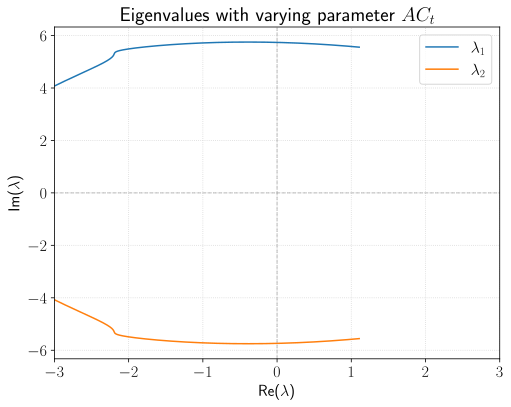

In [8]:
plt.plot(re_part[:, 0], im_part[:, 0], label=r'$\lambda_1$')
plt.plot(re_part[:, 1], im_part[:, 1], label=r'$\lambda_2$')
plt.grid(True, linestyle=':', color='lightgray')
plt.axhline(0, color='grey', linewidth=1, linestyle='--', alpha=0.5)
plt.axvline(0, color='grey', linewidth=1, linestyle='--', alpha=0.5)
plt.xlabel(r'Re($\lambda$)')
plt.ylabel(r'Im($\lambda$)')
plt.title('Eigenvalues with varying parameter $AC_t$')
plt.legend()
plt.xlim(-3,3)
plt.savefig('evalues_corssing_im_axis_AC_t', dpi=300)
plt.show()

In [9]:
camp_equlibrium = [eq[0] for eq in equilibrium_list]
equl_saddle = np.zeros(len(camp_equlibrium))

real_parts_first_eigenvalue = [re[0] for re in re_part]

colors = ['b' if val < 0 else 'r' for val in real_parts_first_eigenvalue]
plt.grid(True, linestyle=':', color='lightgray', zorder=1)
plt.scatter(param_values, camp_equlibrium, c=colors, zorder=2)
plt.scatter(param_values, equl_saddle, c='green', zorder=2)

blue_patch = mpatches.Patch(color='blue', label='Stable spiral', zorder=2)
red_patch = mpatches.Patch(color='red', label='Unstable spiral', zorder=2)
green_patch = mpatches.Patch(color='green', label='Saddle point', zorder=2)
plt.legend(handles=[blue_patch, red_patch, green_patch], loc='right')
plt.title(r'Stability of fixed points with varying parameter $k_1$')
plt.xlabel(r'Parameter value $k_1$')
plt.ylabel('cAMP fixed point')
plt.savefig('bifurcation_stability_k1', dpi=300, bbox_inches='tight')

plt.show()
